In [1]:
import sys
import os
import cv2
import skimage
import numpy as np
import tensorflow
import keras
sys.path.append("..")

Using TensorFlow backend.


In [2]:
#Load images
from skimage import transform
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".jpg")]
        for f in file_names:
            images.append(skimage.data.imread(f))
    return images, labels
ROOT_PATH = ""

In [3]:
train_data_directory = os.path.join(ROOT_PATH, "lfw-deepfunneled/")

In [13]:
x_train, y_train = load_data(train_data_directory)


In [14]:
x_train = [transform.resize(image, (28,28)) for image in x_train]
x_train = np.array(x_train)

('X_train shape:', (13233, 28, 28, 3))


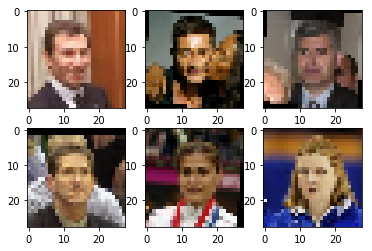

In [18]:
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_train[i])

print("X_train shape:",x_train.shape)
img_shape = x_train[2].shape

In [19]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    NFILTERS=16
    N1=256

    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.normalization.BatchNormalization(axis=1))
    
    #Convolutions
    encoder.add(L.Conv2D(filters=NFILTERS*2,kernel_size=3,padding="same"))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.Conv2D(filters=NFILTERS,kernel_size=3,padding="same"))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.MaxPooling2D())

    
    encoder.add(L.Flatten()) 
    
    encoder.add(L.Dense(N1))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.normalization.BatchNormalization())
    encoder.add(L.Dense(N1))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.normalization.BatchNormalization())    
    
    encoder.add(L.Dense(code_size))
   
    
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.normalization.BatchNormalization())
    
    decoder.add(L.Dense(N1))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.normalization.BatchNormalization())
    decoder.add(L.Dense(N1))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.normalization.BatchNormalization())   
    
    
    decoder.add(L.Dense(np.prod(img_shape)//4))
    decoder.add(L.advanced_activations.LeakyReLU()) 
    decoder.add(L.normalization.BatchNormalization()) 
    decoder.add(L.Reshape((H//2,W//2,C)))   
    decoder.add(L.UpSampling2D())

    decoder.add(L.Deconvolution2D(filters=NFILTERS,kernel_size=3,padding="same"))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Deconvolution2D(filters=NFILTERS*2,kernel_size=3,padding="same")) 
    
    encoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Deconvolution2D(filters=3,kernel_size=3,padding="same"))

    
    return encoder,decoder

In [20]:
import tensorflow as tf
import keras, keras.layers as L
encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)

encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 28, 28, 3)         112       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

In [22]:
autoencoder.compile('nadam','mse')


In [23]:
autoencoder.fit(x=x_train,y=x_train,epochs=120)

Epoch 1/120
13233/13233 [==============================] - 95s 7ms/step - loss: 0.0425
Epoch 2/120
13233/13233 [==============================] - 88s 7ms/step - loss: 0.0317
Epoch 3/120
13233/13233 [==============================] - 87s 7ms/step - loss: 0.0291: 1s - loss:
Epoch 4/120
13233/13233 [==============================] - 90s 7ms/step - loss: 0.0273: 2s - lo
Epoch 5/120
13233/13233 [==============================] - 87s 7ms/step - loss: 0.0258
Epoch 6/120
13233/13233 [==============================] - 74s 6ms/step - loss: 0.0249
Epoch 7/120
13233/13233 [==============================] - 74s 6ms/step - loss: 0.0245
Epoch 8/120
13233/13233 [==============================] - 74s 6ms/step - loss: 0.0239
Epoch 9/120
13233/13233 [==============================] - 100s 8ms/step - loss: 0.0237
Epoch 10/120
13233/13233 [==============================] - 91s 7ms/step - loss: 0.0235
Epoch 11/120
13233/13233 [==============================] - 88s 7ms/step - loss: 0.0232
Epoch 12/120
13233/

13233/13233 [==============================] - 83s 6ms/step - loss: 0.0199
Epoch 94/120
13233/13233 [==============================] - 81s 6ms/step - loss: 0.0199
Epoch 95/120
13233/13233 [==============================] - 78s 6ms/step - loss: 0.0199
Epoch 96/120
13233/13233 [==============================] - 83s 6ms/step - loss: 0.0199
Epoch 97/120
13233/13233 [==============================] - 87s 7ms/step - loss: 0.0199
Epoch 98/120
13233/13233 [==============================] - 84s 6ms/step - loss: 0.0199
Epoch 99/120
13233/13233 [==============================] - 74s 6ms/step - loss: 0.0199
Epoch 100/120
13233/13233 [==============================] - 74s 6ms/step - loss: 0.0199
Epoch 101/120
13233/13233 [==============================] - 74s 6ms/step - loss: 0.0199
Epoch 102/120
13233/13233 [==============================] - 74s 6ms/step - loss: 0.0198
Epoch 103/120
13233/13233 [==============================] - 73s 6ms/step - loss: 0.0199
Epoch 104/120
13233/13233 [==============

/Users/carlosc/anaconda2/lib/python2.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.370838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/Users/carlosc/anaconda2/lib/python2.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.186439). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


13233/13233 [==============================] - 74s 6ms/step - loss: 0.0199
Epoch 106/120
13233/13233 [==============================] - 80s 6ms/step - loss: 0.0198
Epoch 107/120
13233/13233 [==============================] - 97s 7ms/step - loss: 0.0198
Epoch 108/120
13233/13233 [==============================] - 95s 7ms/step - loss: 0.0198
Epoch 109/120
13233/13233 [==============================] - 90s 7ms/step - loss: 0.0198
Epoch 110/120
13233/13233 [==============================] - 87s 7ms/step - loss: 0.0198
Epoch 111/120
13233/13233 [==============================] - 90s 7ms/step - loss: 0.0197
Epoch 112/120
13233/13233 [==============================] - 90s 7ms/step - loss: 0.0197
Epoch 113/120
13233/13233 [==============================] - 94s 7ms/step - loss: 0.0197
Epoch 114/120
13233/13233 [==============================] - 91s 7ms/step - loss: 0.0198
Epoch 115/120
13233/13233 [==============================] - 85s 6ms/step - loss: 0.0197
Epoch 116/120
13233/13233 [========

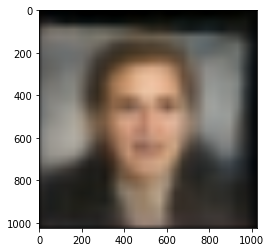

In [82]:
image1,image2 = x_train[np.random.randint(0,len(x_train),size=2)]
code1, code2 = encoder.predict(np.stack([image1,image2]))
output_code = code1*(1-0.5) + code2*(0.5)
output_image = decoder.predict(output_code[None])[0]
output_image = transform.resize(output_image, (1024,1024))
plt.imshow(output_image)

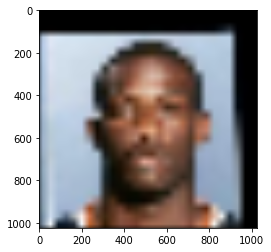

In [92]:
plt.imshow(transform.resize(x_train[20], (1024,1024)))